In [0]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.classification import GBTClassificationModel
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf, array, concat, col
from sentence_transformers import SentenceTransformer
from pyspark.sql.types import ArrayType, FloatType, DoubleType
from pyspark.sql import functions as F
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import DenseVector
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from pyspark.ml.feature import PCA

## Create pseudo-labels for scraped data

In [0]:
# Load GBT Classifier that was trained on the processed kaggle df
gbt_model = GBTClassificationModel.load("/dbfs/Workspace/Users/saarmanshrov@campus.technion.ac.il/gbt_model")

# Run to retrain model
# processed_kaggle_df = pd.read_csv('processed_fake_job_postings.csv')
# gbt = GBTClassifier(labelCol="fraudulent", featuresCol="features", maxDepth=10, maxIter=10, seed=1)
# gbt_model = gbt.fit(processed_kaggle_df) 

In [0]:
stg1 = pd.read_csv('pre_proccessed_data_for_first_stage.csv')
stg2 = pd.read_csv('pre_proccessed_data_for_second_stage.csv')
stg2 = stg2.drop_duplicates(['job_id'])

Process scraped data for before pseudo-labeling

In [0]:
def process_data(df):
    # Rename columns
    remap_cols = {'job_description': 'description', 'job_requirements_gemini': 'requirements', 'required_education_gemini': 'required_education', 'benefits_gemini': 'benefits', 'company_description_gemini': 'company_profile', 'industry_gemini': 'industry', 'department_gemini': 'department', 'job_type': 'employment_type'}
    df.rename(columns=remap_cols, inplace=True)
    df = df[['job_id', 'title', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_education', 'industry']]

    # Replace None with empty string
    df["benefits"] = df["benefits"].replace(to_replace=[None], value="")
    df["company_profile"] = df["company_profile"].replace(to_replace=[None], value="")
    df["description"] = df["description"].replace(to_replace=[None], value="")
    df["requirements"] = df["requirements"].replace(to_replace=[None], value="")

    # Calculate word count
    cols = ['company_profile', 'description', 'requirements', 'benefits']

    for c in cols:
        df[c + '_word_count'] = df[c].str.split().str.len()
    df['total_word_count'] = df.apply(lambda row: sum(row[c].split().__len__() for c in df.columns if isinstance(row[c], str)), axis=1)

    # Create all_text column
    cols = ['title', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_education', 'industry']
    df['all_text'] = df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    df = df[['job_id', 'all_text', 'company_profile_word_count', 'description_word_count', 'requirements_word_count', 'benefits_word_count', 'total_word_count']]

    df = spark.createDataFrame(df)

    # Load pre-trained sentence transformer model
    model = SentenceTransformer('all-MiniLM-L6-v2') 

    # UDF to embed text using Sentence Transformer
    def embed_text(text):
        return model.encode([text]).tolist()[0] 

    # Register the UDF with Spark
    embed_udf = udf(embed_text, ArrayType(FloatType())) 

    # Apply the UDF to the DataFrame
    df = df.withColumn("embeddings_vector", embed_udf("all_text"))

    # Normalize count columns
    word_count_cols = ["company_profile_word_count", "description_word_count", "requirements_word_count", "benefits_word_count", "total_word_count"]
    for wc_col in word_count_cols:
        min_value = df.agg({f"{wc_col}": "min"}).collect()[0][0]
        max_value = df.agg({f"{wc_col}": "max"}).collect()[0][0]

        df = df.withColumn(
            f"{wc_col}_normalized",
            (F.col(wc_col) - min_value) / (max_value - min_value)
        )

    # Create numeric_features_array
    df = df.withColumn(
        "numeric_features_array",
        array(*[F.col(f"{wc_col}_normalized") for wc_col in word_count_cols])
    )

    # Concatenate the numeric array with embeddings_vector
    df = df.withColumn(
        "concatenated_features",
        concat(col("numeric_features_array"), col("embeddings_vector"))
        )

    def array_to_vector(array):
        return Vectors.dense(array)

    array_to_vector_udf = udf(array_to_vector, VectorUDT())

    # Convert embeddings column to DenseVector
    df = df.withColumn("features", array_to_vector_udf("concatenated_features"))
    return df

In [0]:
# Process the data for Method 1
stg1_processed = process_data(stg1)

/root/.ipykernel/1225/command-1256467050976307-1441995035:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["benefits"] = df["benefits"].replace(to_replace=[None], value="")
/root/.ipykernel/1225/command-1256467050976307-1441995035:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["company_profile"] = df["company_profile"].replace(to_replace=[None], value="")
/root/.ipykernel/1225/command-1256467050976307-1441995035:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Tag scraped data with Pseudo labels 

In [0]:
stg1_processed.cache()
# Make predictions on stg1 scraped data (not yet enriched)
predictions = gbt_model.transform(stg1_processed)
predictions.toPandas().to_csv("first_stage_predictions.csv", index=False)

In [0]:
# Organize the predictions
predictions = pd.read_csv("first_stage_predictions.csv")
predictions["probabilityArray"] = predictions["probability"].apply(json.loads)
predictions["features"] = predictions["features"].apply(json.loads)
predictions = spark.createDataFrame(predictions)

Mark high confidence pseudo-labels 

In [0]:
# Create a new column to indicate whether to use the data for training (probability higher than 0.8)
predictions = predictions.withColumn(
    "useForTraining",
    F.when((col("prediction") == 0) & (col("probabilityArray")[0] >= 0.8), True)
    .when((col("prediction") == 1) & (col("probabilityArray")[1] >= 0.8), True)
    .otherwise(False)
)

In [0]:
# Count how many useForTraining were tagged as fraudelent and how many were not
predictions.groupBy("useForTraining", "prediction").count().display()

useForTraining,prediction,count
true,0.0,4931
false,0.0,130
true,1.0,45
false,1.0,130


Select high-confidence pseudo-labeled data for training and validating

In [0]:
# Sample the non-fraudulent data to match the fraudulent data (45 fraudulent vs ~1000 non-fraudulent)
non_fraud = predictions.filter((col("prediction") == 0) & (col("useForTraining") == True))
non_fraud_sampled = non_fraud.sample(False, 1000 / non_fraud.count(), seed=42)
fraud = predictions.filter((col("prediction") == 1) & (col("useForTraining") == True))

# Split the fraud/non_fraud data to train/val
train_fraud, val_fraud = fraud.randomSplit([0.8, 0.2], seed=42)
train_non_fraud, val_non_fraud = non_fraud_sampled.randomSplit([0.8, 0.2], seed=42)

# Combine the data
train_data = train_fraud.union(train_non_fraud)
val_data = val_fraud.union(val_non_fraud)

train_data.toPandas().to_csv("train_data.csv", index=False)
val_data.toPandas().to_csv("val_data.csv", index=False)

In [0]:

# Helper function for evaluation

def calculate_eval_metrics(preds, method_num):
    # Evaluate F1 score
    f1_evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="f1"
    )
    f1_score = f1_evaluator.evaluate(preds)

    # Assuming stg1_preds is a Spark DataFrame with columns 'label' and 'prediction'
    preds_pd = preds.select('label', 'prediction').toPandas()

    # Calculate balanced accuracy
    balanced_acc = balanced_accuracy_score(preds_pd['label'], preds_pd['prediction'])

    # Display the results
    results = pd.DataFrame({"F1 Score": [f1_score], "Balanced Accuracy": [balanced_acc]})
    display(results)

    # Compute confusion matrix
    cm = confusion_matrix(preds_pd['label'], preds_pd['prediction'])

    # Plot confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for Method {method_num} Predictions')
    plt.show()
    
    return results


### Method 1: Train model

In [0]:
# Convert the data to the correct format
array_to_vector = F.udf(lambda a: Vectors.dense(a), VectorUDT())
train_data = train_data.withColumn("features", array_to_vector("features"))
train_data = train_data.withColumnRenamed("prediction", "label")
train_data = train_data.drop("rawPrediction", "probability")

val_data = val_data.withColumn("features", array_to_vector("features"))
val_data = val_data.withColumnRenamed("prediction", "label")
val_data = val_data.drop("rawPrediction", "probability")

In [0]:
# Train the model 
# gbt_stg1 = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10, seed=1)
# gbt_stg1_model = gbt_stg1.fit(train_data)
# gbt_stg1_model.save("/dbfs/Workspace/Users/shani.angel@campus.technion.ac.il/gbt_stg1_model")

# Load trained model instead of retraining the model
gbt_stg1_model = GBTClassificationModel.load("/dbfs/Workspace/Users/shani.angel@campus.technion.ac.il/gbt_stg1_model")
# Tag the validation set
stg1_preds = gbt_stg1_model.transform(val_data)


## Evaluate Method 1 Model

F1 Score,Balanced Accuracy
0.9435091971997384,0.6161242603550297


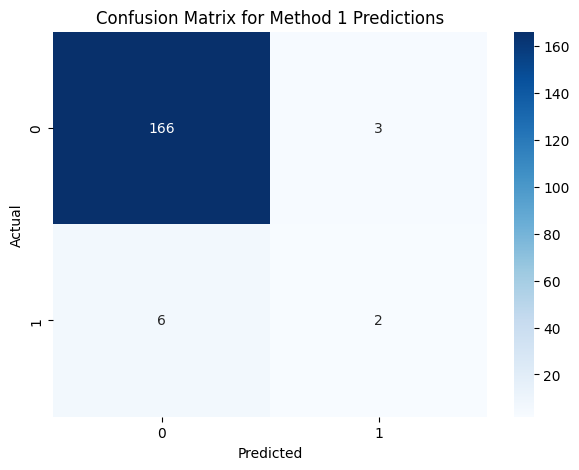

In [0]:
stg1_results = calculate_eval_metrics(stg1_preds, 1)

## Method 2: Train model

In [0]:
# Process data for Stage 2

def process_data_2(df, additional_cols=[]):
    # Rename columns
    remap_cols = {'job_description': 'description', 'job_requirements_gemini': 'requirements', 'required_education_gemini': 'required_education', 'benefits_gemini': 'benefits', 'company_description_gemini': 'company_profile', 'industry_gemini': 'industry', 'department_gemini': 'department', 'job_type': 'employment_type'}
    df.rename(columns=remap_cols, inplace=True)
    df = df[['job_id', 'title', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_education', 'industry'] + additional_cols]
    df["benefits"] = df["benefits"].replace(to_replace=[None], value="")
    df["company_profile"] = df["company_profile"].replace(to_replace=[None], value="")
    df["description"] = df["description"].replace(to_replace=[None], value="")
    df["requirements"] = df["requirements"].replace(to_replace=[None], value="")

    cols = ['company_profile', 'description', 'requirements', 'benefits']

    for c in cols:
        df[c + '_word_count'] = df[c].str.split().str.len()
    
    df['total_word_count'] = df.apply(lambda row: sum(row[c].split().__len__() for c in df.columns if isinstance(row[c], str)), axis=1)
    cols = ['title', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_education', 'industry']
    df['all_text'] = df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    df = df[['job_id', 'all_text', 'company_profile_word_count', 'description_word_count', 'requirements_word_count', 'benefits_word_count', 'total_word_count'] + additional_cols]

    df = spark.createDataFrame(df)
    # Load pre-trained sentence transformer model
    model = SentenceTransformer('all-MiniLM-L6-v2') 

    # UDF to embed text using Sentence Transformer
    def embed_text(text):
        return model.encode([text]).tolist()[0] 

    # Register the UDF with Spark
    embed_udf = udf(embed_text, ArrayType(FloatType()))  

    # Apply the UDF to the DataFrame
    df = df.withColumn("embeddings_vector", embed_udf("all_text"))


    word_count_cols = ["company_profile_word_count", "description_word_count", "requirements_word_count", "benefits_word_count", "total_word_count"]
    for wc_col in word_count_cols:
        min_value = df.agg({f"{wc_col}": "min"}).collect()[0][0]
        max_value = df.agg({f"{wc_col}": "max"}).collect()[0][0]

        df = df.withColumn(
            f"{wc_col}_normalized",
            (F.col(wc_col) - min_value) / (max_value - min_value)
        )

    numeric_features = [F.col(f"{wc_col}_normalized") for wc_col in word_count_cols] + additional_cols
    df = df.withColumn(
        "numeric_features_array",
        array(*numeric_features)
    )

    # Concatenate the numeric array with embeddings_vector
    df = df.withColumn(
        "concatenated_features",
        concat(col("numeric_features_array"), col("embeddings_vector"))
        )


    def array_to_vector(array):
        return Vectors.dense(array)

    array_to_vector_udf = udf(array_to_vector, VectorUDT())

    # Convert embeddings column to DenseVector
    df = df.withColumn("features", array_to_vector_udf("concatenated_features"))
    return df

In [0]:
# Engineered features based on the companies big data
additional_features = ['affiliate_ratio','followers_to_avg','employees_to_avg','industry_rank_score','investors_len','updates_len','funding_rounds','company_size_index','cluster_number','subtitle_diversity_ratio','funding_to_avg','about_similarity']

for c in additional_features:
    stg2[c] = stg2[c].fillna(0)

stg2_processed = process_data_2(stg2, additional_features)
stg2_processed.cache()

/root/.ipykernel/1225/command-1256467050976322-3557101440:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["benefits"] = df["benefits"].replace(to_replace=[None], value="")
/root/.ipykernel/1225/command-1256467050976322-3557101440:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["company_profile"] = df["company_profile"].replace(to_replace=[None], value="")
/root/.ipykernel/1225/command-1256467050976322-3557101440:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

DataFrame[job_id: bigint, all_text: string, company_profile_word_count: bigint, description_word_count: bigint, requirements_word_count: bigint, benefits_word_count: bigint, total_word_count: bigint, affiliate_ratio: double, followers_to_avg: double, employees_to_avg: double, industry_rank_score: double, investors_len: bigint, updates_len: bigint, funding_rounds: double, company_size_index: double, cluster_number: bigint, subtitle_diversity_ratio: double, funding_to_avg: double, about_similarity: double, embeddings_vector: array<float>, company_profile_word_count_normalized: double, description_word_count_normalized: double, requirements_word_count_normalized: double, benefits_word_count_normalized: double, total_word_count_normalized: double, numeric_features_array: array<double>, concatenated_features: array<double>, features: vector]

In [0]:
# Train and validate on the same high-confidence pseudo-labeled scraped data 
train_labels = train_data.select("job_id", "label")
val_labels = val_data.select("job_id", "label")

stg2_train_data = stg2_processed.join(train_labels, stg2_processed.job_id == train_labels.job_id, "inner")
stg2_val_data = stg2_processed.join(val_labels, stg2_processed.job_id == val_labels.job_id, "inner")

In [0]:
# Train Method 2 model
# gbt_stg2 = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10, seed=1)
# gbt_stg2_model = gbt_stg2.fit(stg2_train_data)
# gbt_stg2_model.save("/dbfs/Workspace/Users/shani.angel@campus.technion.ac.il/gbt_stg2_model")

# Load trained model instead of retraining
gbt_stg2_model = GBTClassificationModel.load("/dbfs/Workspace/Users/shani.angel@campus.technion.ac.il/gbt_stg2_model")
# Tag the validation set
stg2_preds = gbt_stg2_model.transform(stg2_val_data)


## Evaluate Method 2 Model

F1 Score,Balanced Accuracy
0.9435091971997384,0.6161242603550297


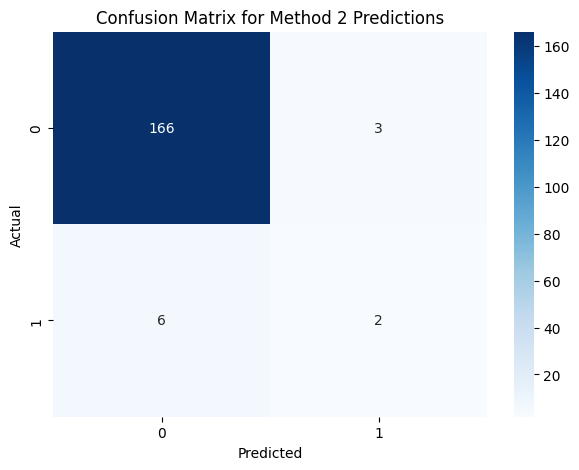

In [0]:
stg2_results = calculate_eval_metrics(stg2_preds, 2)

## Method 3: Train Model

In [0]:
# Process Method 3 data (no text embedding)
def process_data_3(df, additional_cols=[]):
    df = df[['job_id', 'company_profile', 'description', 'requirements', 'benefits'] + additional_cols]
    df["benefits"] = df["benefits"].replace(to_replace=[None], value="")
    df["company_profile"] = df["company_profile"].replace(to_replace=[None], value="")
    df["description"] = df["description"].replace(to_replace=[None], value="")
    df["requirements"] = df["requirements"].replace(to_replace=[None], value="")
    cols = ['company_profile', 'description', 'requirements', 'benefits']
    for c in cols:
        df[c + '_word_count'] = df[c].str.split().str.len()
    df['total_word_count'] = df.apply(lambda row: sum(row[c].split().__len__() for c in df.columns if isinstance(row[c], str)), axis=1)

    df = spark.createDataFrame(df)

    word_count_cols = ["company_profile_word_count", "description_word_count", "requirements_word_count", "benefits_word_count", "total_word_count"]
    for wc_col in word_count_cols:
        min_value = df.agg({f"{wc_col}": "min"}).collect()[0][0]
        max_value = df.agg({f"{wc_col}": "max"}).collect()[0][0]

        df = df.withColumn(
            f"{wc_col}_normalized",
            (F.col(wc_col) - min_value) / (max_value - min_value)
        )

    numeric_features = [F.col(f"{wc_col}_normalized") for wc_col in word_count_cols] + additional_cols
    df = df.withColumn(
        "concatenated_features",
        array(*numeric_features)
    )

    def array_to_vector(array):
        return Vectors.dense(array)
    array_to_vector_udf = udf(array_to_vector, VectorUDT())

    # Convert features column to DenseVector
    df = df.withColumn("features", array_to_vector_udf("concatenated_features"))
    return df

In [0]:
# Process Method 3 data
stg3_processed = process_data_3(stg2, additional_features)

/root/.ipykernel/1225/command-8881827304329695-2770780890:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["benefits"] = df["benefits"].replace(to_replace=[None], value="")
/root/.ipykernel/1225/command-8881827304329695-2770780890:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["company_profile"] = df["company_profile"].replace(to_replace=[None], value="")
/root/.ipykernel/1225/command-8881827304329695-2770780890:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [0]:
# Train and validate on the same high-confidence pseudo-labeled scraped data 
train_labels = train_data.select("job_id", "label")
val_labels = val_data.select("job_id", "label")

stg3_train_data = stg3_processed.join(train_labels, stg3_processed.job_id == train_labels.job_id, "inner")
stg3_val_data = stg3_processed.join(val_labels, stg3_processed.job_id == val_labels.job_id, "inner")

In [0]:
# Train Method 3 model
# gbt_stg3 = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10, seed=1)
# gbt_stg3_model = gbt_stg3.fit(stg3_train_data)
# gbt_stg3_model.write().overwrite().save("/dbfs/Workspace/Users/shani.angel@campus.technion.ac.il/gbt_stg3_model")

# Load trained model instead of retraining
gbt_stg3_model = GBTClassificationModel.load("/dbfs/Workspace/Users/shani.angel@campus.technion.ac.il/gbt_stg3_model")

# Tag the validation set
stg3_preds = gbt_stg3_model.transform(stg3_val_data)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

## Evaluate Method 3 Model

F1 Score,Balanced Accuracy
0.92130042620676,0.4881656804733728


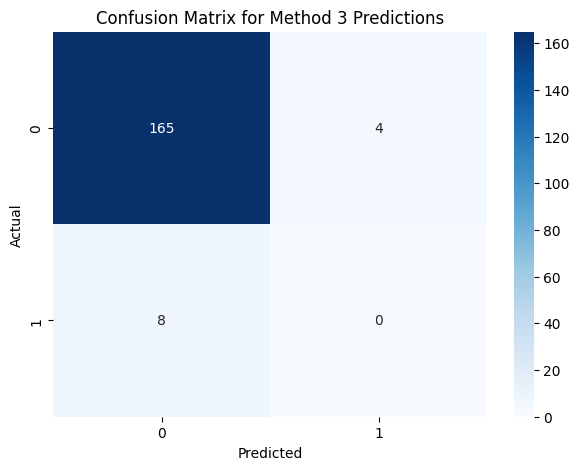

In [0]:
stg3_results = calculate_eval_metrics(stg3_preds, 3)

## Method 4: Train model

In [0]:
# Process Method 4 data (reduced text embedding dimension)

def process_data_4(df, additional_cols=[]):
    remap_cols = {'job_description': 'description', 'job_requirements_gemini': 'requirements', 
                  'required_education_gemini': 'required_education', 'benefits_gemini': 'benefits', 
                  'company_description_gemini': 'company_profile', 'industry_gemini': 'industry', 
                  'department_gemini': 'department', 'job_type': 'employment_type'}
    
    df.rename(columns=remap_cols, inplace=True)
    df = df[['job_id', 'title', 'department', 'company_profile', 'description', 'requirements', 
             'benefits', 'employment_type', 'required_education', 'industry'] + additional_cols]
    
    df["benefits"] = df["benefits"].replace(to_replace=[None], value="")
    df["company_profile"] = df["company_profile"].replace(to_replace=[None], value="")
    df["description"] = df["description"].replace(to_replace=[None], value="")
    df["requirements"] = df["requirements"].replace(to_replace=[None], value="")

    cols = ['company_profile', 'description', 'requirements', 'benefits']
    for c in cols:
        df[c + '_word_count'] = df[c].str.split().str.len()

    df['total_word_count'] = df.apply(lambda row: sum(row[c].split().__len__() for c in df.columns if isinstance(row[c], str)), axis=1)
    cols = ['title', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_education', 'industry']
    df['all_text'] = df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    df = df[['job_id', 'all_text', 'company_profile_word_count', 'description_word_count', 
             'requirements_word_count', 'benefits_word_count', 'total_word_count'] + additional_cols]

    df = spark.createDataFrame(df)

    # Load pre-trained sentence transformer model
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # UDF to embed text using Sentence Transformer
    def embed_text(text):
        return model.encode([text]).tolist()[0]  

    embed_udf = udf(embed_text, ArrayType(FloatType()))
    df = df.withColumn("embeddings_vector", embed_udf("all_text"))

    # Normalize word count columns
    word_count_cols = ["company_profile_word_count", "description_word_count", "requirements_word_count", "benefits_word_count", "total_word_count"]
    for wc_col in word_count_cols:
        min_value = df.agg({f"{wc_col}": "min"}).collect()[0][0]
        max_value = df.agg({f"{wc_col}": "max"}).collect()[0][0]

        df = df.withColumn(
            f"{wc_col}_normalized",
            (col(wc_col) - min_value) / (max_value - min_value)
        )

    numeric_features = [col(f"{wc_col}_normalized") for wc_col in word_count_cols] + additional_cols

    numeric_features_casted = [col(f"{wc_col}_normalized").cast("float") for wc_col in word_count_cols] + [col(c).cast("float") for c in additional_cols]

    df = df.withColumn("numeric_features_array", array(*numeric_features_casted))


    # Apply PCA to reduce dimensionality of embeddings
    df = df.withColumn("embeddings_vector_dense", udf(lambda x: Vectors.dense(x), VectorUDT())(col("embeddings_vector")))
    pca_dim = 50  
    pca = PCA(k=pca_dim, inputCol="embeddings_vector_dense", outputCol="pca_embeddings")
    pca_model = pca.fit(df)
    df = pca_model.transform(df)

    def extract_values_from_vector(vect):
        if isinstance(vect, DenseVector):
            return vect.values.tolist()  
        return []

    # Register the UDF
    extract_values_udf = udf(extract_values_from_vector, ArrayType(FloatType()))

    # Apply the UDF to the DataFrame to get the values as an array
    df = df.withColumn("pca_embeddings_array", extract_values_udf(col("pca_embeddings")))

    # Concatenate the numeric array with embeddings_vector
    df = df.withColumn(
        "concatenated_features",
        concat(col("numeric_features_array"), col("pca_embeddings_array"))
        )

    # Convert concatenated array to dense vector for model training
    def array_to_vector(array):
        return Vectors.dense(array)

    array_to_vector_udf = udf(array_to_vector, VectorUDT())
    df = df.withColumn("features", array_to_vector_udf("concatenated_features"))
    
    return df


In [0]:
# Process data for stage 4
additional_features = ['affiliate_ratio','followers_to_avg','employees_to_avg','industry_rank_score','investors_len','updates_len','funding_rounds','company_size_index','cluster_number','subtitle_diversity_ratio','funding_to_avg','about_similarity']

for c in additional_features:
    stg2[c] = stg2[c].fillna(0)

stg4_processed = process_data_4(stg2, additional_features)

/root/.ipykernel/1225/command-8881827304330131-1924403650:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["benefits"] = df["benefits"].replace(to_replace=[None], value="")
/root/.ipykernel/1225/command-8881827304330131-1924403650:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["company_profile"] = df["company_profile"].replace(to_replace=[None], value="")
/root/.ipykernel/1225/command-8881827304330131-1924403650:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [0]:
# Train and validate on the same high-confidence pseudo-labeled scraped data 
train_labels = train_data.select("job_id", "label")
val_labels = val_data.select("job_id", "label")

stg4_train_data = stg4_processed.join(train_labels, stg4_processed.job_id == train_labels.job_id, "inner")
stg4_val_data = stg4_processed.join(val_labels, stg4_processed.job_id == val_labels.job_id, "inner")

In [0]:
# Train model
# gbt_stg4 = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10, seed=1)
# gbt_stg4_model = gbt_stg4.fit(stg4_train_data)
# gbt_stg4_model.save("/dbfs/Workspace/Users/shani.angel@campus.technion.ac.il/gbt_stg4_model")

# load instead of running
gbt_stg4_model = GBTClassificationModel.load("/dbfs/Workspace/Users/shani.angel@campus.technion.ac.il/gbt_stg4_model")
# Tag validation set
stg4_preds = gbt_stg4_model.transform(stg4_val_data)


F1 Score,Balanced Accuracy
0.9395887510564251,0.6697485207100592


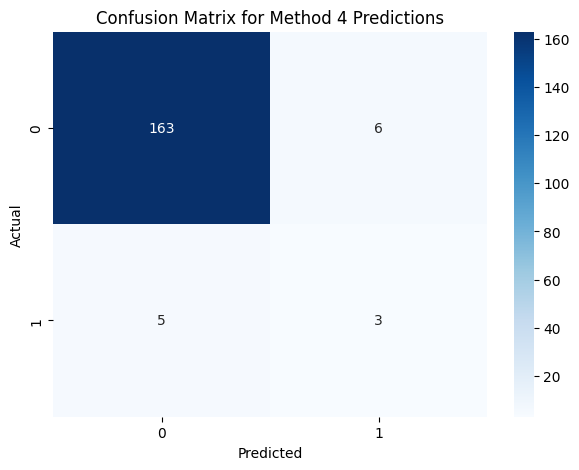

In [0]:
stg4_results = calculate_eval_metrics(stg4_preds, 4)

## Tag all scraped data using Method 4 model

In [0]:
# Process all scraped data using Method 4
scraped_processed = process_data_4(stg2, additional_features)

# Make predictions
scraped_predictions = gbt_stg4_model.transform(scraped_processed)
scraped_predictions.toPandas().to_csv("scraped_predictions_method_4.csv", index=False)

/root/.ipykernel/1225/command-8881827304330131-1924403650:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["benefits"] = df["benefits"].replace(to_replace=[None], value="")
/root/.ipykernel/1225/command-8881827304330131-1924403650:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["company_profile"] = df["company_profile"].replace(to_replace=[None], value="")
/root/.ipykernel/1225/command-8881827304330131-1924403650:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D